In [1]:
import os.path

import scanpy as sc
import scanpy.external as sce
from flecs.utils import set_seed, get_project_root
import random
import numpy as np
from flecs.sc.utils import get_cell_indices, adapt_source_population_size, \
    compute_optimal_transport, compute_env_shortest_paths_with_ot, plot_cell_type_distribution
import matplotlib.pyplot as plt

sc.set_figure_params(figsize=(16, 8))
set_seed(0)

In [2]:
use_magic = True
normalize_per_cell = True
normalize_gene_std = False
use_log1p = False

## Load

In [3]:
adata = sc.read_h5ad(os.path.join(get_project_root(), 
                                  "datasets", "Paul15", "processed", "paul15_with_mouse_grn.h5ad")
                    )
# Restrict to relevant cell populations
adata = adata[adata.obs["Batch_desc"].apply(lambda n: n in ['Unsorted myeloid',
                                                            'CMP Flt3+ Csf1r+', 
                                                            'Cebpe KO', 
                                                            'Cebpa KO'])].copy()

In [4]:
adata.layers["counts"] = adata.X

## Highly variable genes

In [5]:
sc.pp.filter_genes(adata, min_counts=1)
if normalize_per_cell:
    sc.pp.normalize_per_cell(adata, key_n_counts='n_counts_all')

# Find highly variable genes
if not use_log1p:
    adata_copy = sc.pp.log1p(adata, copy=True)
    sc.pp.highly_variable_genes(adata_copy, n_top_genes=4000, flavor='cell_ranger')  # Expects logged data

    adata.var['highly_variable'] = adata_copy.var['highly_variable']
else:
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=4000, flavor='cell_ranger')

In [6]:
adata.var['highly_variable']["Cebpa"]

True

In [7]:
adata.var['highly_variable']["Cebpe"]

True

In [8]:
adata.var['highly_variable'].sum()

4000

In [9]:
if use_magic:
    sce.pp.magic(adata, t=3, n_pca=300, verbose=True)

Calculating MAGIC...
  Running MAGIC on 7296 cells and 11757 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 4.82 seconds.
    Calculating KNN search...
    Calculated KNN search in 20.44 seconds.
    Calculating affinities...
    Calculated affinities in 20.09 seconds.
  Calculated graph and diffusion operator in 45.36 seconds.
  Running MAGIC with `solver='exact'` on 11757-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 17.54 seconds.
Calculated MAGIC in 62.99 seconds.


In [10]:
adata = adata[:, adata.var['highly_variable']].copy()
# Renormalize after filtering
if normalize_per_cell:
    sc.pp.normalize_per_cell(adata)
if normalize_gene_std:
    adata.X /= adata.X.std(axis=0)
    
adata.obs.reset_index(inplace=True)

## Compute cell paths

In [11]:
if use_magic:
    sc.tl.pca(adata, svd_solver="arpack", n_comps=200)
    sc.pp.neighbors(adata, n_neighbors=100, n_pcs=200)
    sc.tl.umap(adata, min_dist=0.3)
else:
    sc.tl.pca(adata, svd_solver="arpack", n_comps=200)
    sc.pp.neighbors(adata, n_neighbors=7, n_pcs=50)
    sc.tl.umap(adata, min_dist=0.3)

In [12]:
# Get cell indices coming from the different batches
cmp_cells, unsorted_cells, cebpa_cells, cebpe_cells = get_cell_indices(adata)
random.seed(0)
random.shuffle(cmp_cells)
random.shuffle(unsorted_cells)
random.shuffle(cebpa_cells)
random.shuffle(cebpe_cells)

resampled_cmp_cells = adapt_source_population_size(cmp_cells, unsorted_cells)
ot_mapping = compute_optimal_transport(adata, resampled_cmp_cells, unsorted_cells)

unsorted_shortest_paths = compute_env_shortest_paths_with_ot(adata, "Unsorted myeloid")
cebpa_ko_shortest_paths = compute_env_shortest_paths_with_ot(adata, "Cebpa KO")
cebpe_ko_shortest_paths = compute_env_shortest_paths_with_ot(adata, "Cebpe KO")

# Convert keys to strings
unsorted_shortest_paths = {str(k): v for k, v in unsorted_shortest_paths.items()}
cebpa_ko_shortest_paths = {str(k): v for k, v in cebpa_ko_shortest_paths.items()}
cebpe_ko_shortest_paths = {str(k): v for k, v in cebpe_ko_shortest_paths.items()}

adata.uns["unsorted_shortest_paths"] = unsorted_shortest_paths
adata.uns["cebpa_ko_shortest_paths"] = cebpa_ko_shortest_paths
adata.uns["cebpe_ko_shortest_paths"] = cebpe_ko_shortest_paths

100%|██████████████████████████████████████████████████████████████| 768/768 [00:17<00:00, 43.43it/s]


## Save

In [13]:
if use_magic:
    adata.write_h5ad(os.path.join(get_project_root(), 
                                  "datasets", "Paul15", "processed", "adata_processed_with_paths_magic.h5ad")
                )
else:
    adata.write_h5ad(os.path.join(get_project_root(), 
                                      "datasets", "Paul15", "processed", "adata_processed_with_paths.h5ad")
                )

## Plot

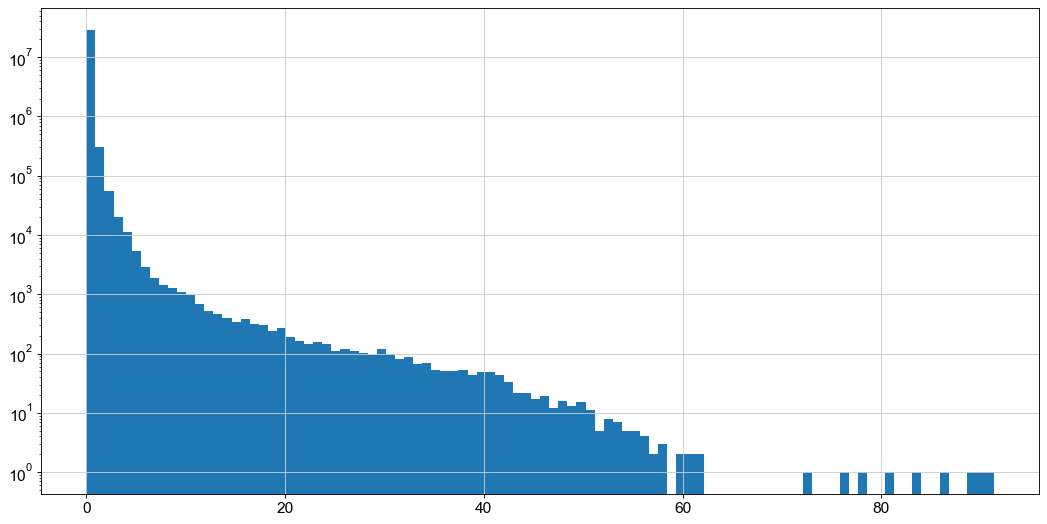

In [14]:
plt.hist(adata.X.reshape(-1), bins=100)
plt.yscale("log")
plt.show()

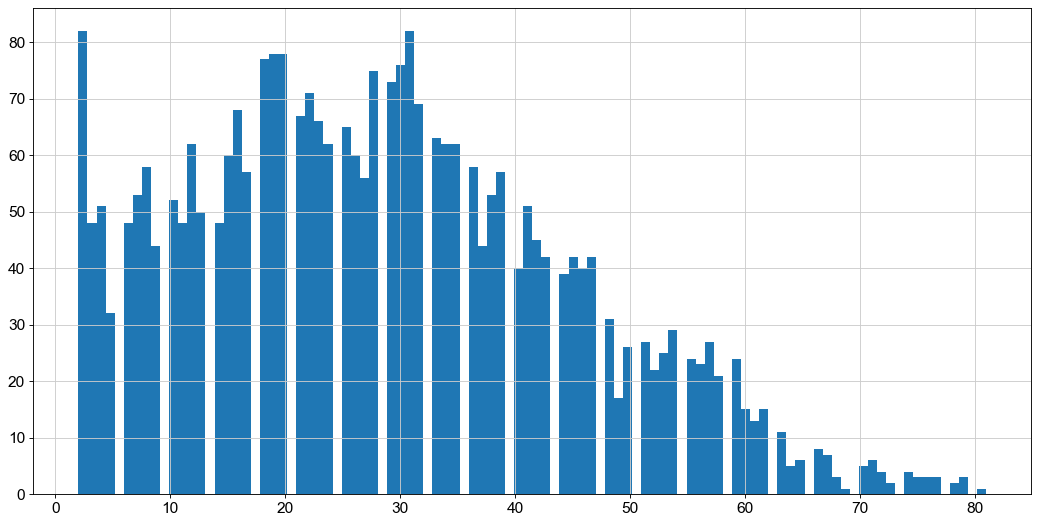

In [15]:
plt.hist([len(v) for v in adata.uns["unsorted_shortest_paths"].values()], bins=100)
plt.show()

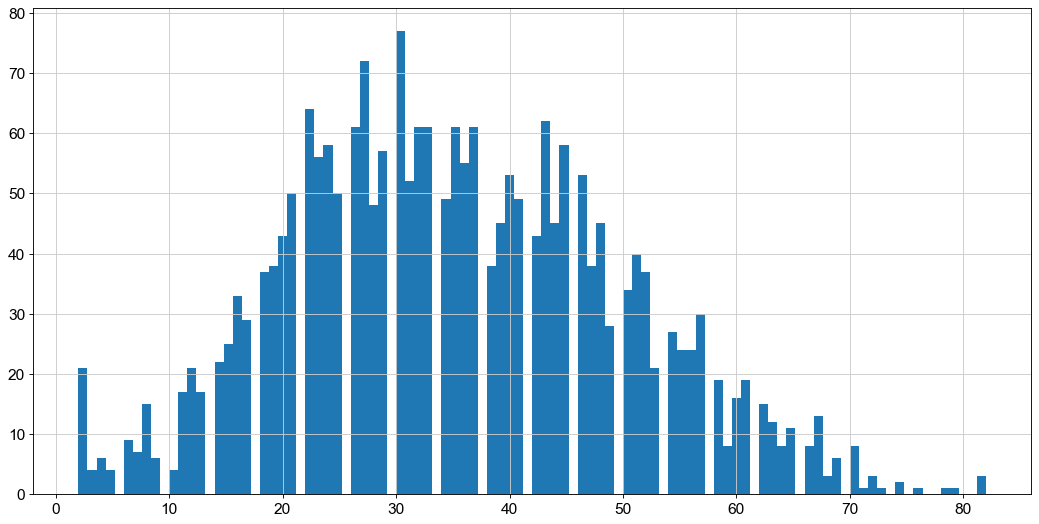

In [18]:
plt.hist([len(v) for v in adata.uns["cebpa_ko_shortest_paths"].values()], bins=100)
plt.show()

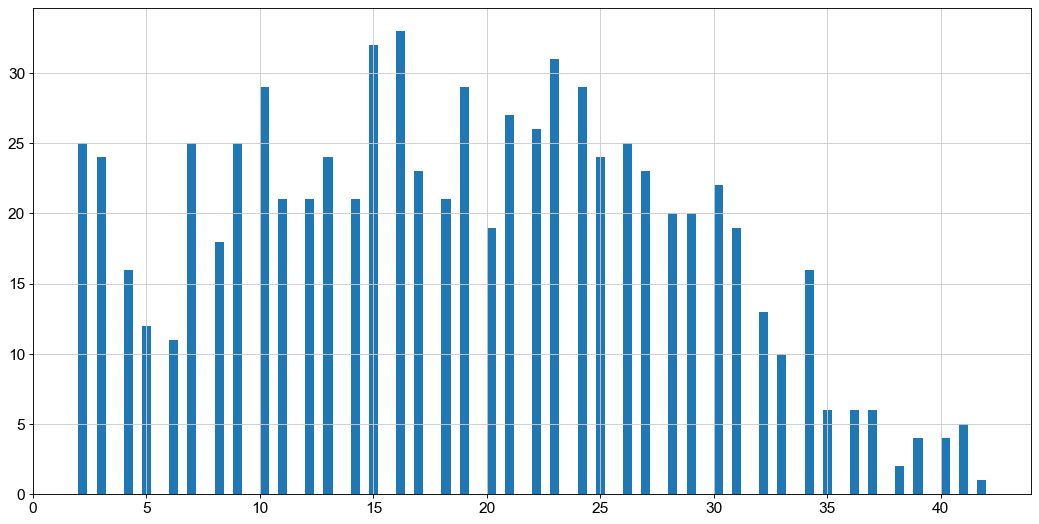

In [19]:
plt.hist([len(v) for v in adata.uns["cebpe_ko_shortest_paths"].values()], bins=100)
plt.show()

/Users/paul/miniconda3/envs/flecs/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


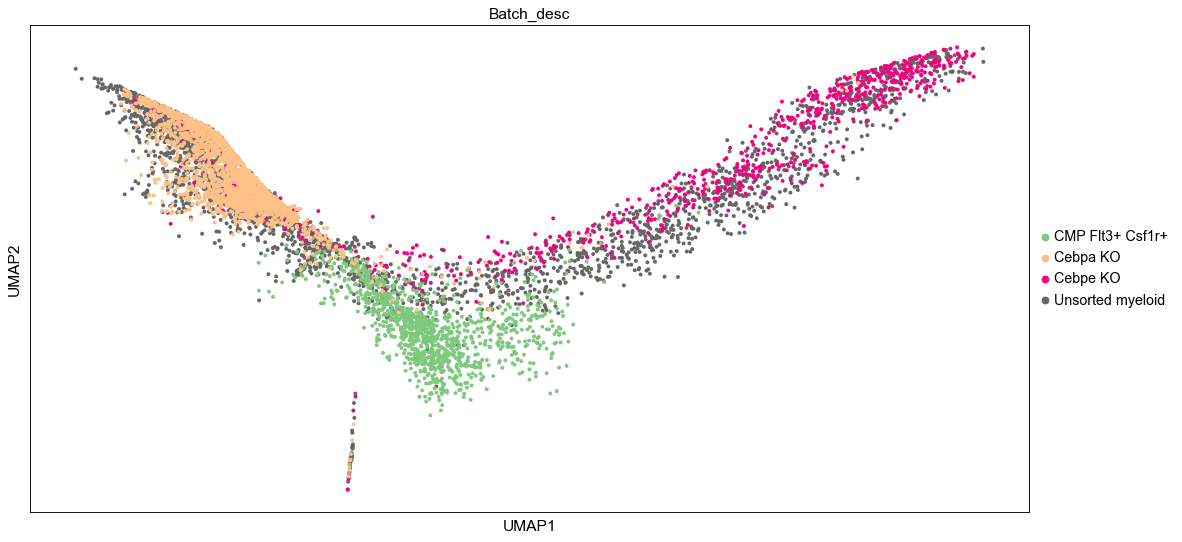

In [13]:
sc.pl.umap(adata, color="Batch_desc", palette="Accent", legend_loc='right margin', size=50)

/Users/paul/miniconda3/envs/flecs/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/paul/miniconda3/envs/flecs/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


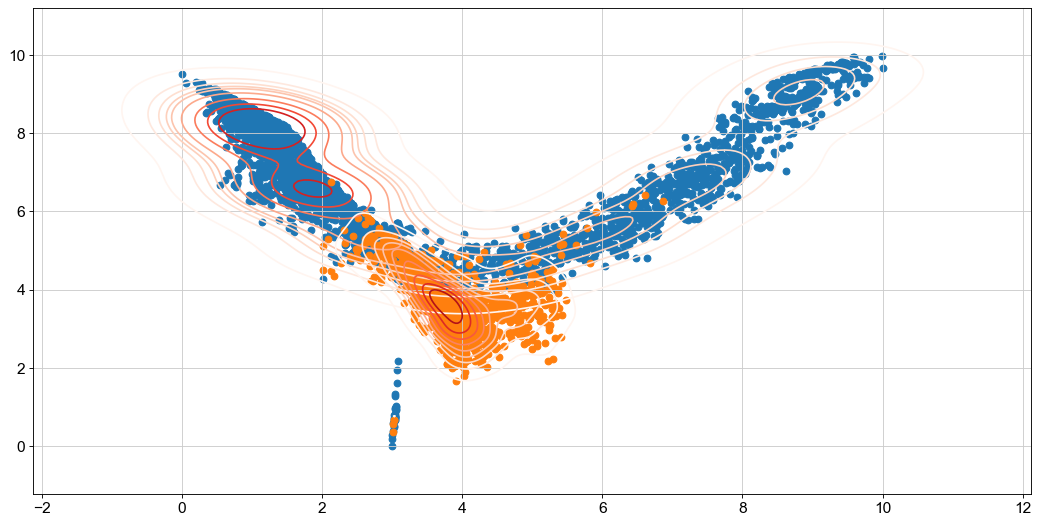

In [18]:
plot_cell_type_distribution(adata, 'Unsorted myeloid')
plot_cell_type_distribution(adata, 'CMP Flt3+ Csf1r+')
plt.show()

/Users/paul/miniconda3/envs/flecs/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/paul/miniconda3/envs/flecs/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


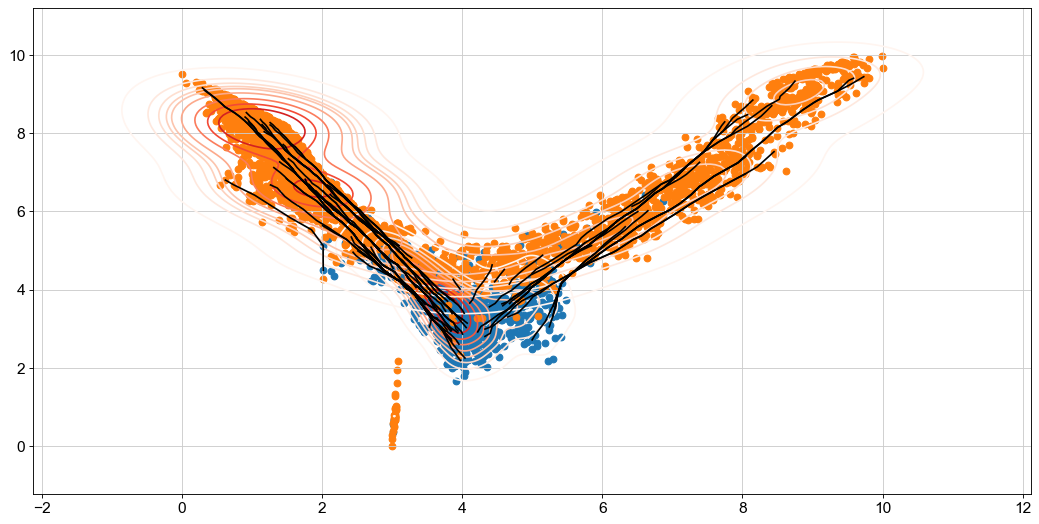

In [27]:
plot_cell_type_distribution(adata, 'CMP Flt3+ Csf1r+')
plot_cell_type_distribution(adata, 'Unsorted myeloid')

for i, path in enumerate(unsorted_shortest_paths.values()):
    if i % 50 == 2:
        path_coord = adata.obsm["X_umap"][path]
        plt.plot(path_coord[:, 0], path_coord[:, 1], c="k")

plt.show()

/Users/paul/miniconda3/envs/flecs/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/paul/miniconda3/envs/flecs/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


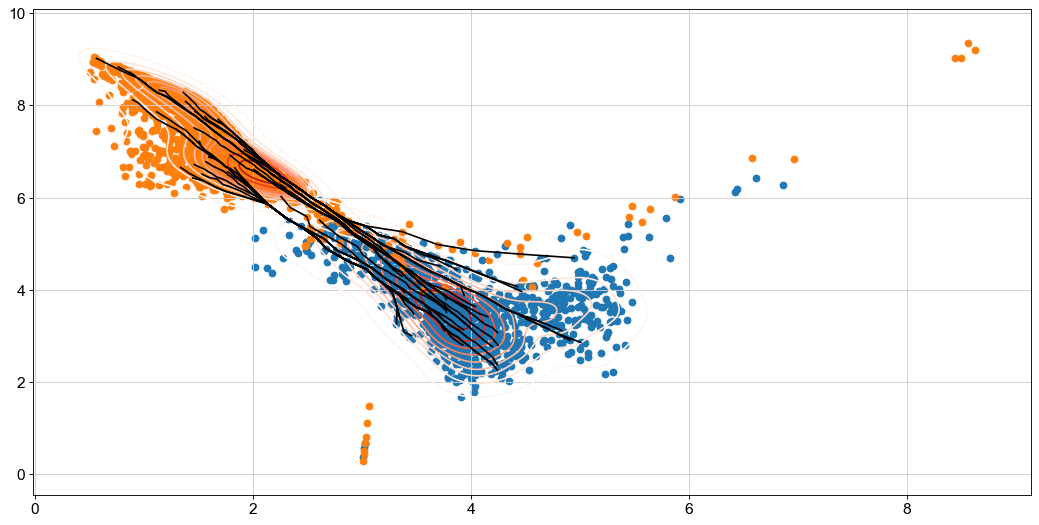

In [29]:
plot_cell_type_distribution(adata, 'CMP Flt3+ Csf1r+')
plot_cell_type_distribution(adata, 'Cebpa KO')

for i, path in enumerate(cebpa_ko_shortest_paths.values()):
    if i % 50 == 1:
        path_coord = adata.obsm["X_umap"][path]
        plt.plot(path_coord[:, 0], path_coord[:, 1], c="k")

plt.show()

/Users/paul/miniconda3/envs/flecs/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/paul/miniconda3/envs/flecs/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


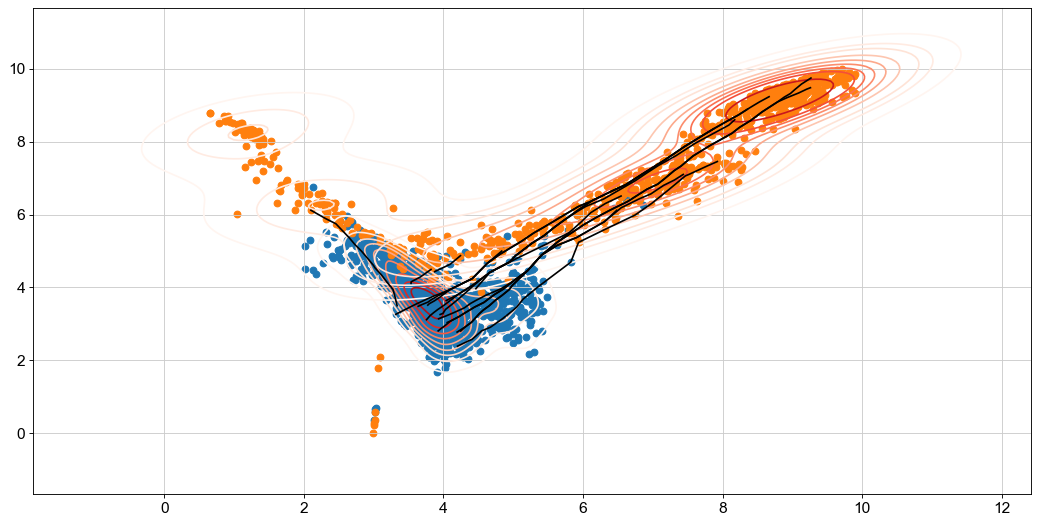

In [31]:
plot_cell_type_distribution(adata, 'CMP Flt3+ Csf1r+')
plot_cell_type_distribution(adata, 'Cebpe KO')

for i, path in enumerate(cebpe_ko_shortest_paths.values()):
    if i % 50 == 1:
        path_coord = adata.obsm["X_umap"][path]
        plt.plot(path_coord[:, 0], path_coord[:, 1], c="k")

plt.show()

/Users/paul/miniconda3/envs/flecs/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


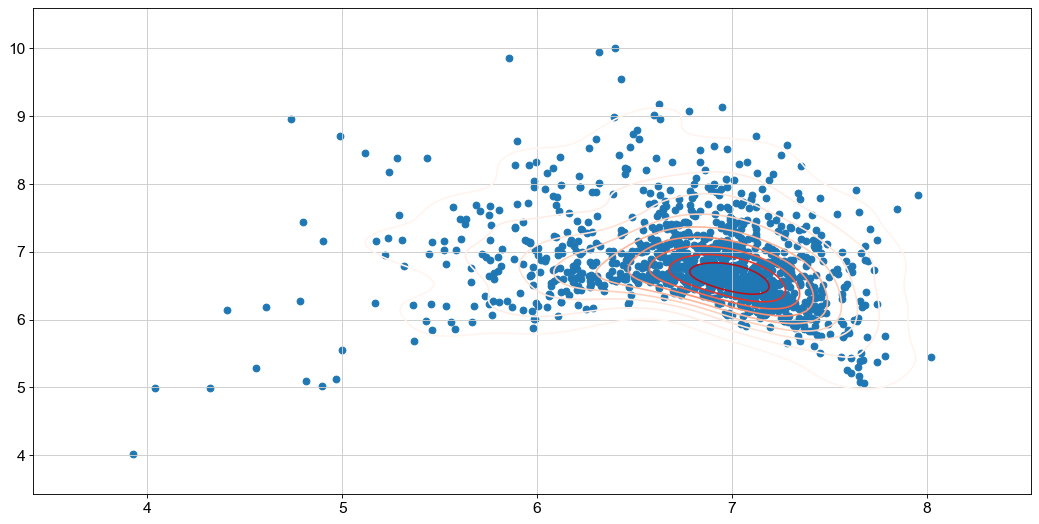

In [19]:
plot_cell_type_distribution(adata, 'CMP Flt3+ Csf1r+')

/Users/paul/miniconda3/envs/flecs/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


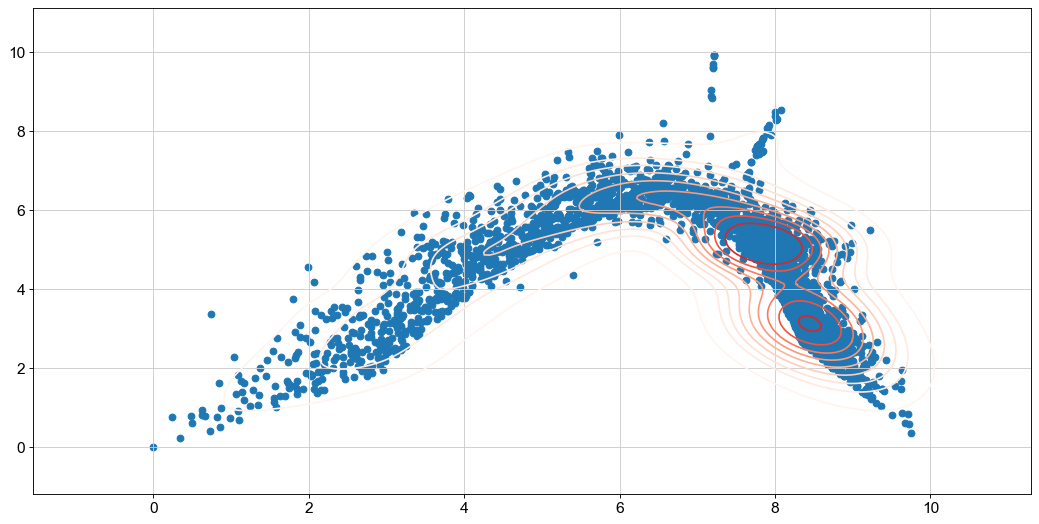

In [20]:
plot_cell_type_distribution(adata, 'Unsorted myeloid')

/Users/paul/miniconda3/envs/flecs/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


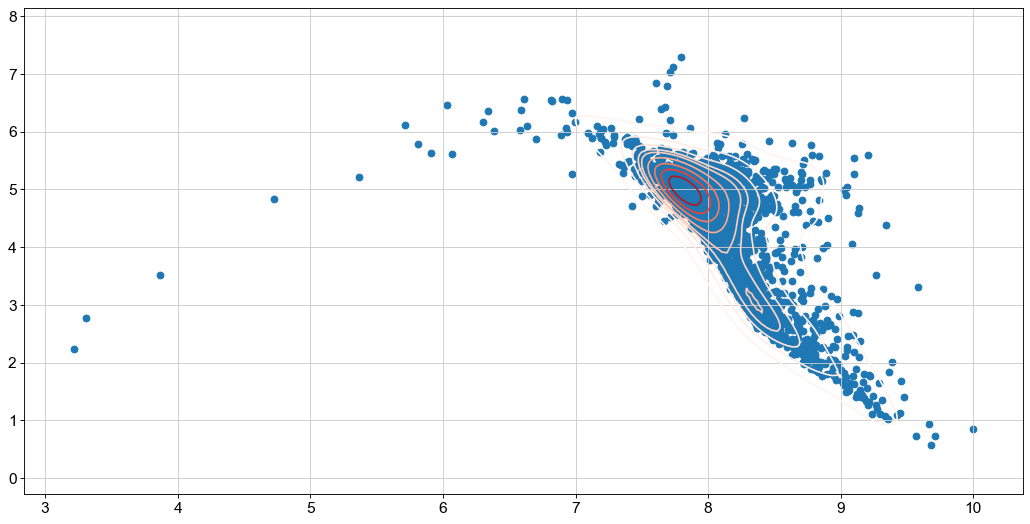

In [21]:
plot_cell_type_distribution(adata, 'Cebpa KO')

/Users/paul/miniconda3/envs/flecs/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


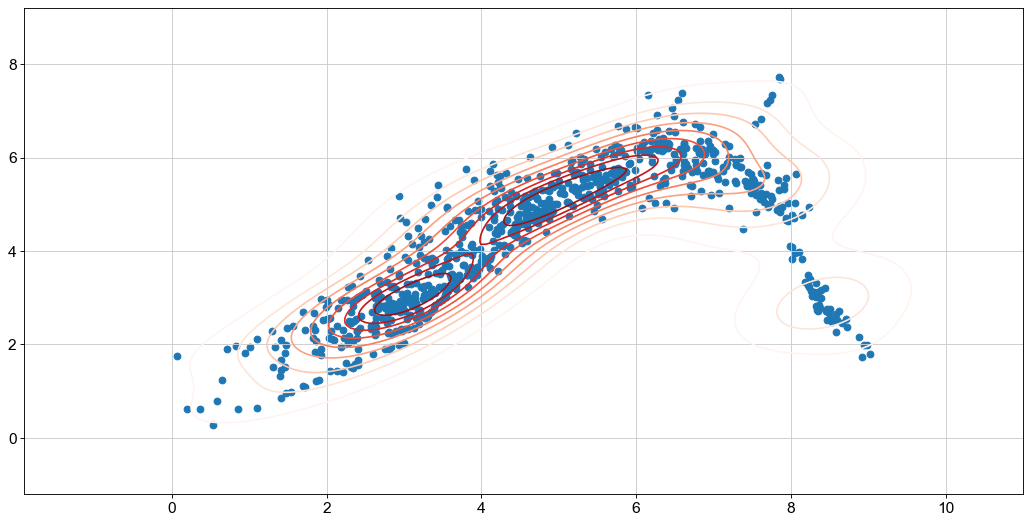

In [22]:
plot_cell_type_distribution(adata, 'Cebpe KO')